# Utils

In [1]:
import random
random.seed(1)
from warnings import filterwarnings
filterwarnings(action='ignore')
import datetime
import pickle
import gc
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from feature_selection_functions import generate_metadata
from reg_log_functions import plot_variable_vs_logodds, calculate_r2_for_logodds, calculate_r2_for_logodds_and_transformations, apply_best_transformations , analyze_variable, categorize_with_decision_tree, apply_tree_bins, logistic_regression_with_scorecard, calculate_metrics

In [2]:
def plot_variable_vs_logodds(df, variables, target):
    for variable in variables:
        # Verificando o número de valores únicos
        unique_vals = df[variable].nunique()
        if unique_vals == 1:
            print(f"{variable} tem apenas um valor único. Ignorando...")
            continue

        n_bins = min(10, unique_vals)

        # Criando bins para a variável
        df['bin'] = pd.cut(df[variable], bins=n_bins, labels=False, duplicates='drop')

        # Calculando a proporção de eventos positivos para cada bin
        mean_target = df.groupby('bin')[target].mean()

        # Calculando o log(odds) e tratando valores infinitos
        log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

        # Calculando R^2
        X = df.groupby('bin')[variable].mean()[log_odds.index].values.reshape(-1, 1)
        y = log_odds.values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        # Plotando
        plt.figure(figsize=(8, 6))
        plt.plot(X, y, marker='o')
        plt.xlabel(variable)
        plt.ylabel('Log(Odds)')
        plt.title(f'{variable} vs Log(Odds) of {target}\nR^2 = {r2:.2f}')
        plt.grid(True)
        plt.show()

        # Removendo a coluna bin
        df.drop('bin', axis=1, inplace=True)



# Função para plotar o R² (linearidade) com a LogOdds
def calculate_r2_for_logodds(df, variables, target, threshold):
    results = []

    for variable in variables:
        # Verificando o número de valores únicos
        unique_vals = df[variable].nunique()
        if unique_vals == 1:
            print(f"{variable} tem apenas um valor único. Ignorando...")
            continue

        n_bins = min(10, unique_vals)

        # Criando bins para a variável
        df['bin'] = pd.cut(df[variable], bins=n_bins, labels=False, duplicates='drop')

        # Calculando a proporção de eventos positivos para cada bin
        mean_target = df.groupby('bin')[target].mean()

        # Calculando o log(odds) e tratando valores infinitos
        log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

        # Calculando R^2
        X = df.groupby('bin')[variable].mean()[log_odds.index].values.reshape(-1, 1)
        y = log_odds.values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        # Decidindo sobre a engenharia de recursos com base no valor de R^2 e no threshold fornecido
        feat_eng = "Usar como contínua" if r2 > threshold else "Categorizar"

        results.append({
            'Variable': variable,
            'R^2': r2,
            'Feat Eng': feat_eng
        })

        # Removendo a coluna bin
        df.drop('bin', axis=1, inplace=True)

    return pd.DataFrame(results)


# Transformações para as variáveis de baixo R²
def calculate_r2_for_logodds_and_transformations(df, variables, target, threshold):
    results = []

    transformations = {
        'AbsLog': lambda x: np.log(np.abs(x) + 1),  # Adicionamos 1 para evitar log(0)
        'Quadratic': lambda x: x**2
    }

    for variable in variables:
        best_transform_r2 = -np.inf
        best_transform_name = 'None'
        best_transform_function = None

        for transform_name, transform_function in transformations.items():
            transformed_var = transform_function(df[variable])

            # Verificando o número de valores únicos
            unique_vals = transformed_var.nunique()
            if unique_vals == 1:
                continue

            n_bins = min(10, unique_vals)

            # Criando bins para a variável transformada
            df['bin'] = pd.cut(transformed_var, bins=n_bins, labels=False, duplicates='drop')

            # Calculando a proporção de eventos positivos para cada bin
            mean_target = df.groupby('bin')[target].mean()

            # Calculando o log(odds) e tratando valores infinitos
            log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

            # Calculando R^2
            X = df.groupby('bin')[transformed_var.name].mean()[log_odds.index].values.reshape(-1, 1)
            y = log_odds.values
            model = LinearRegression().fit(X, y)
            r2 = model.score(X, y)

            # Se essa transformação for a melhor até agora, atualize as melhores variáveis
            if r2 > best_transform_r2:
                best_transform_r2 = r2
                best_transform_name = transform_name
                best_transform_function = transform_function

            # Removendo a coluna bin
            df.drop('bin', axis=1, inplace=True)

        feat_eng = "Usar como contínua" if best_transform_r2 > threshold else "Categorizar"

        results.append({
            'Variable': variable,
            'Best Transformation': best_transform_name,
            'R^2 of Transformation': best_transform_r2,
            'Feat Eng': feat_eng,
            'Transformation Equation': f'{best_transform_name}({variable})'
        })

    return pd.DataFrame(results)


# Função que aplica as melhores transformações
def apply_best_transformations(results_df, original_df, drop_original=False):
    transformed_df = original_df.copy()

    transformations = {
        'LogAbs': lambda x: np.log(np.abs(x) + 1),
        'Quadratic': lambda x: x**2
    }

    variables_transformed = []

    for index, row in results_df.iterrows():
        variable = row['Variable']
        best_transform_name = row['Best Transformation']
        feat_eng = row['Feat Eng']

        # Aplica a transformação apenas se Feat Eng estiver marcada como "Categorizar"
        if feat_eng == 'Usar como contínua' and best_transform_name in transformations:
            transform_function = transformations[best_transform_name]
            transformed_var = transform_function(original_df[variable])
            transformed_df[f'TFE_{variable}'] = transformed_var
            variables_transformed.append(variable)

    # Descarta as variáveis originais se drop_original for True
    if drop_original:
        transformed_df.drop(variables_transformed, axis=1, inplace=True)

    return transformed_df



# Função para checar se existe ordenação entre categorias
def analyze_variable(dataframe, variable, target):

    # Se a variável for numérica, arredonda para 4 casas decimais
    if pd.api.types.is_numeric_dtype(dataframe[variable]):
        dataframe[variable] = dataframe[variable].round(4)
        dataframe[variable] = dataframe[variable].astype(str)

    # Calcula a taxa de evento e o volume para cada categoria da variável
    result = dataframe.groupby(variable).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
    result.columns = [variable, 'Taxa_de_Evento', 'Volume']

    # Ordena o resultado pela Taxa de Evento em ordem decrescente
    result = result.sort_values(by='Taxa_de_Evento', ascending=False)

    # Plota o gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eixo Y esquerdo: Volume
    bars = ax1.bar(result[variable], result['Volume'], color='lightblue', label='Volume (Barras)')
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Volume', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Eixo Y direito: Taxa de Evento
    ax2 = ax1.twinx()
    lines = ax2.plot(result[variable], result['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink', label='Taxa de Evento (Linha)')
    ax2.set_ylabel('Taxa de Evento (%)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combina as legendas de ambos os eixos, filtrando rótulos que começam com '_'
    plots = [item for item in bars + tuple(lines) if not item.get_label().startswith('_')]
    labels = [plot.get_label() for plot in plots]
    plt.legend(plots, labels, loc='upper left')

    plt.title(f'Volume e Taxa de Evento por {variable}')
    plt.xticks(rotation=45)  # Adicionado para melhor visualização dos labels no eixo X
    plt.tight_layout()
    plt.show()

    return result

# Função de Categorização com Decision Tree
def categorize_with_decision_tree(dataframe, n_categories, target, numeric_var):
    import numpy as np
    # Preparar os dados
    X = dataframe[[numeric_var]]
    y = dataframe[target]

    # Treinar uma árvore de decisão com profundidade máxima igual ao número de categorias desejadas
    tree = DecisionTreeClassifier(max_leaf_nodes=n_categories)
    tree.fit(X, y)

    # Predizer a categoria (folha) para cada entrada no DataFrame
    leaf_ids = tree.apply(X)

    # Criar um DataFrame temporário com as categorias (folhas), a variável numérica e o target
    temp_df = pd.DataFrame({numeric_var: dataframe[numeric_var], 'Leaf': leaf_ids, target: y})

    result = temp_df.groupby('Leaf').agg({target: 'mean', numeric_var: ['count', 'min', 'max']}).reset_index()
    result.columns = ['Leaf', 'Taxa_de_Evento', 'Volume', 'Lower_Bound', 'Upper_Bound']

    # Ajuste para garantir que os limites superior e inferior de bins adjacentes não se sobreponham
    result = result.sort_values(by='Lower_Bound')
    for i in range(1, len(result)):
        result.iloc[i, 3] = max(result.iloc[i, 3], result.iloc[i-1, 4])

    # Definir o limite inferior do primeiro bin como -inf e o limite superior do último bin como inf
    result.iloc[0, 3] = -np.inf
    result.iloc[-1, 4] = np.inf

    return result



# Função de Categorização com Decision Tree
def apply_tree_bins(data, transformation_df, numeric_var):

    result.Upper_Bound = result.Upper_Bound.astype('float')
    result.Lower_Bound = result.Lower_Bound.astype('float')

    import numpy as np
    df_copy = data.copy()

    # Obtenha os limites superiores e ordene-os
    upper_bounds = transformation_df['Upper_Bound'].sort_values().values

    # Use numpy.digitize para determinar a qual bin cada valor pertence
    df_copy[f"TFT_{numeric_var}"] = np.digitize(df_copy[numeric_var].astype(float), upper_bounds)
    df_copy.drop(axis=1,columns=[numeric_var],inplace=True)

    return df_copy


# Função para aplicar a Reg. Log

def logistic_regression_with_scorecard(data, target_var, features):

    data = data[features+[target_var]].copy()

    # Adicionando uma constante ao dataset (intercepto)
    data = sm.add_constant(data)

    # Ajustando o modelo de regressão logística
    model = sm.Logit(data[target_var], data[features + ['const']]).fit()
    # model = sm.Logit(data[target_var], data[features]).fit()

    # Coletando p-valores e estatísticas de Wald
    summary = model.summary2().tables[1]
    summary['Wald'] = summary['z']**2
    scorecard = summary[['Coef.', 'P>|z|', 'Wald']]
    scorecard.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
    scorecard = scorecard.sort_values(by='Wald Statistic', ascending=False)

    return model, scorecard


# Função para Gerar as Métricas de Modelo e Ordenação dos Decis

def calculate_metrics(train_df, test_df, score_column, score_0, target_column,bins=10):
    def compute_metrics(df, score_column, score_0, target_column):
        df_sorted = df.sort_values(by=score_column, ascending=False)

        # Calcular KS
        df_sorted['cum_good'] = (1 - df_sorted[target_column]).cumsum() / (1 - df_sorted[target_column]).sum()
        df_sorted['cum_bad'] = df_sorted[target_column].cumsum() / df_sorted[target_column].sum()
        df_sorted['ks'] = np.abs(df_sorted['cum_good'] - df_sorted['cum_bad'])
        ks_statistic = df_sorted['ks'].max()

        # Calcular AUC
        auc_value = roc_auc_score(df_sorted[target_column], df_sorted[score_column])

        # Calcular Gini
        gini = 2 * auc_value - 1

        # Dividir o score em 10 faixas
        df_sorted['decile'] = pd.qcut(df_sorted[score_0], bins, labels=False)

        # Criar tabela detalhada
        table = df_sorted.groupby('decile').agg(
            min_score=pd.NamedAgg(column=score_0, aggfunc='min'),
            max_score=pd.NamedAgg(column=score_0, aggfunc='max'),
            event_rate=pd.NamedAgg(column=target_column, aggfunc='mean'),
            volume=pd.NamedAgg(column=target_column, aggfunc='size')
        ).reset_index()

        return ks_statistic, auc_value, gini, table

    ks_train, auc_train, gini_train, table_train = compute_metrics(train_df, score_column, score_0, target_column)
    ks_test, auc_test, gini_test, table_test = compute_metrics(test_df, score_column, score_0, target_column)

    # Plotando o gráfico de barras para Event Rate por Decil
    barWidth = 0.3
    r1 = np.arange(len(table_train))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, table_train['event_rate'], color='lightblue', width=barWidth, label='Train')
    plt.bar(r2, table_test['event_rate'], color='royalblue', width=barWidth, label='Test')

    plt.xlabel('Decile')
    plt.ylabel('Event Rate')
    plt.title('Event Rate by Decile')
    plt.xticks([r + barWidth for r in range(len(table_train))], table_train['decile'])
    plt.legend()
    plt.show()

    # Criando DataFrame para as métricas
    metrics_df = pd.DataFrame({
        'Metric': ['KS', 'AUC', 'Gini'],
        'Train Value': [ks_train, auc_train, gini_train],
        'Test Value': [ks_test, auc_test, gini_test]
    })

    return metrics_df, table_train, table_test

# Carregamento e Split

* Carregando os dados

In [3]:
train_data = pd.read_parquet('./BASES_TREINO_TESTE/APPLICATION_TRAIN_FINAL')
train_data.shape

(215257, 220)

* Realizando o Split

In [4]:
X = train_data.drop(columns=['SK_ID_CURR', 'TARGET'])
y = train_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 1)

# Dataprep

* Separando as variáveis (numericas/categóricas) para os conjuntos de Treino e Teste

In [5]:
# Separando as variáveis numéricas e categóricas em dataframes (Treino e Teste)
num_vars_train = X_train.select_dtypes(exclude='object')
cat_vars_train = X_train.select_dtypes(include='object')

num_vars_test = X_test[num_vars_train.columns]
cat_vars_test = X_test[cat_vars_train.columns]

# Separando o nome das variáveis numéricas e categóricas
num_vars = num_vars_train.columns
cat_vars = cat_vars_train.columns

* ``Tratando Missings`` (Numericos e Categoricos) para os conjuntos de Treino e Teste

In [6]:
# Definindo o Imputer para variáveis numéricas e categóricas
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')


# Criando um dataframe com missings preenchidos (Variáveis Numéricas - Treino & Teste)
df_train = pd.DataFrame(imputer_num.fit_transform(num_vars_train), columns= num_vars)
df_test = pd.DataFrame(imputer_num.transform(num_vars_test), columns= num_vars)


# Mantendo os Indexes
df_train.index = num_vars_train.index
df_test.index = num_vars_test.index


# Atualizando os dataframes - Variáveis Numéricas
num_vars_train = df_train.copy()
num_vars_test = df_test.copy()


# Criando um dataframe com missings preenchidos (Variáveis Categóricas - Treino & Teste)
df_train = pd.DataFrame(imputer_cat.fit_transform(cat_vars_train), columns= cat_vars)
df_test = pd.DataFrame(imputer_cat.transform(cat_vars_test), columns= cat_vars)


# Mantendo os Indexes
df_train.index = cat_vars_train.index
df_test.index = cat_vars_test.index


# Atualizando os dataframes - Variáveis Categóricas
cat_vars_train = df_train.copy()
cat_vars_test = df_test.copy()

* Aplicando Encoding nas Variáveis Categóricas (Target Encoding - Treino & Teste)

In [7]:
# Instanciando o Encoder
ce = TargetEncoder()

# Aplicando o Encoder - Treino & Teste
cat_vars_train = ce.fit_transform(cat_vars_train, y_train)
cat_vars_test = ce.transform(cat_vars_test, y_test)

* Criando um novo dataframe com o resultado do DataPrep

In [8]:
abt_train = pd.concat([num_vars_train, cat_vars_train], axis=1)
abt_test = pd.concat([num_vars_test, cat_vars_test], axis=1)

# Feature Selection

* Etapa 1 - Removendo Variáveis Altamente Correlacionadas

In [9]:
# Definindo um valor de corte
threshold = 0.5

# Calculando a matriz de correlação
corr_matrix = abt_train.corr().abs()

# Eliminando a diagonal inferior
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identificando as variáveis que possuem correlação > que o valor de corte
vars_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > threshold)]

# Atualizando nossa abt
abt_train = abt_train.drop(columns= vars_to_drop)
abt_test = abt_test.drop(columns= vars_to_drop)

* Etapa 2 - Remover Via Feature Importance (XGBoostClassifier)

In [ ]:
# Instanciando o modelo
xgb_model = XGBClassifier(random_state = 1)

# Fittando o modelo
xgb_model.fit(abt_train, y_train)

# Criando uma tabela com a feature importance
importances_df = pd.DataFrame({
    'vars' : abt_train.columns,
    'importance' : xgb_model.feature_importances_
})

# Selecionando as 20 melhores variáveis
best_vars = importances_df.sort_values(by= 'importance', ascending= False)[:20].vars.tolist()

# Atualizando nossa abt
abt_train = abt_train[best_vars].copy()
abt_test = abt_test[best_vars].copy()

# Verificando a Linearidade com a LogOdds

* Juntando o conjunto de treino com o target

In [ ]:
abt_train_full = pd.concat([abt_train, y_train], axis=1)
abt_test_full = pd.concat([abt_test, y_test], axis=1)

* Chamando a Função para plotar os gráficos

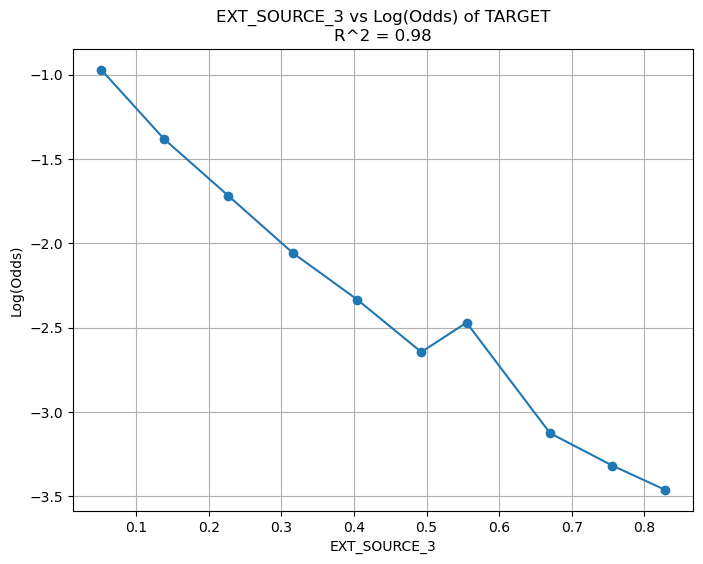

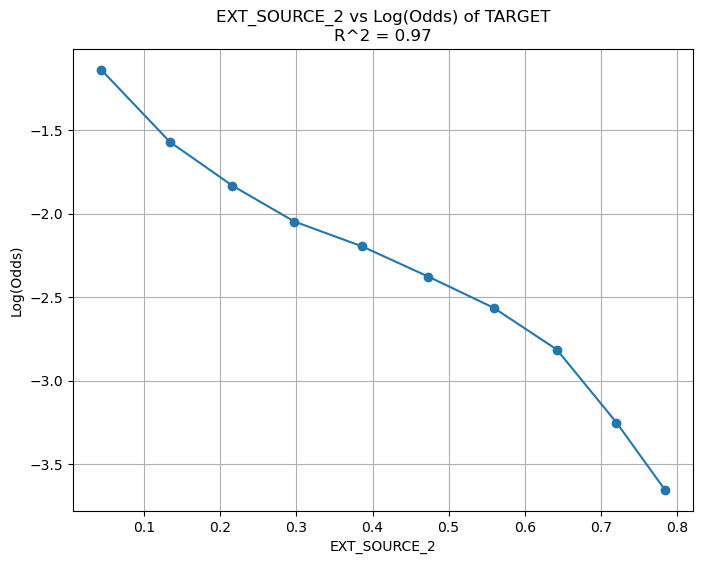

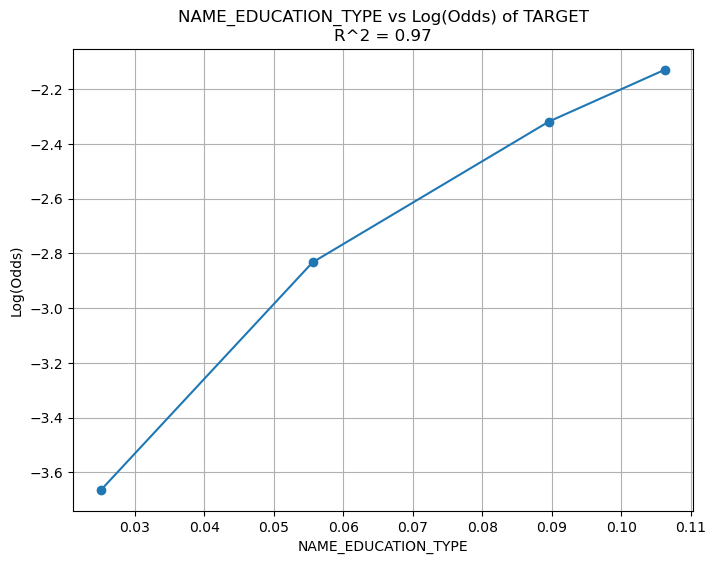

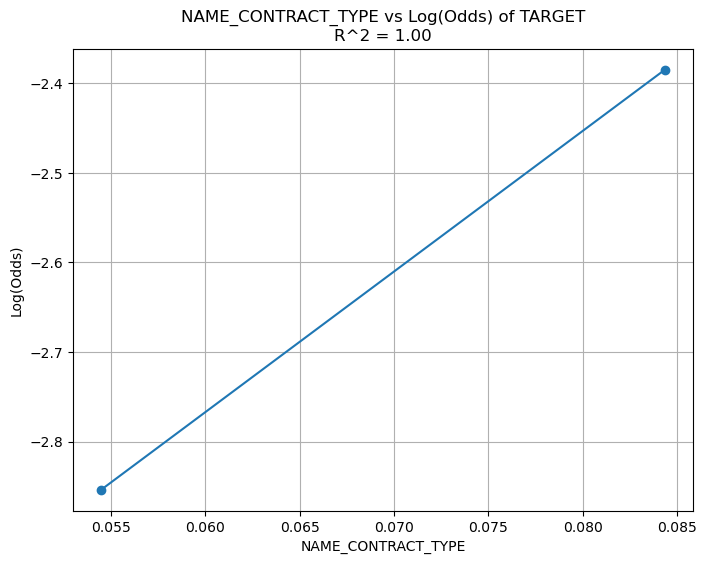

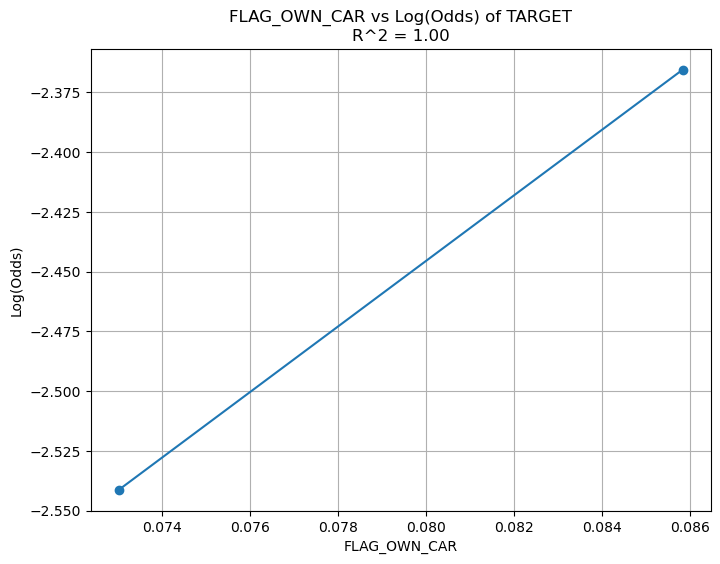

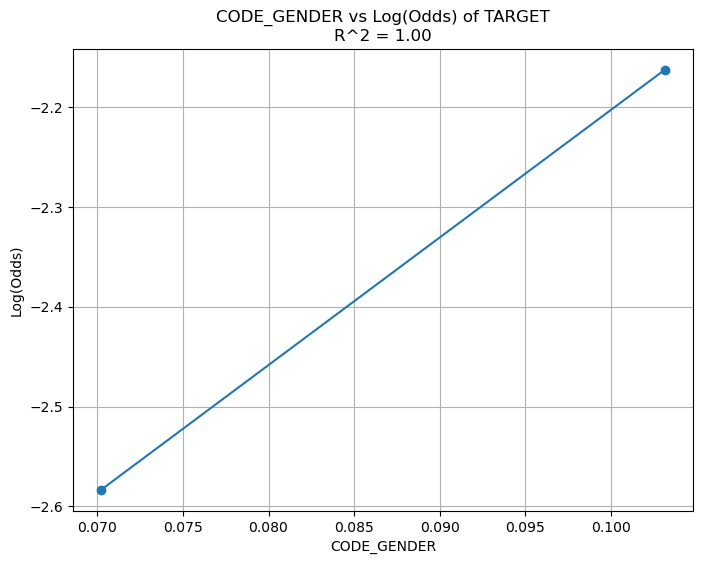

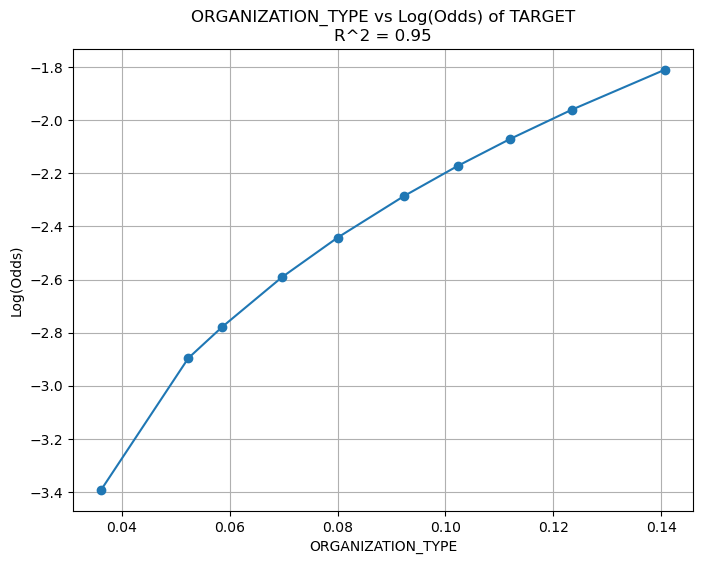

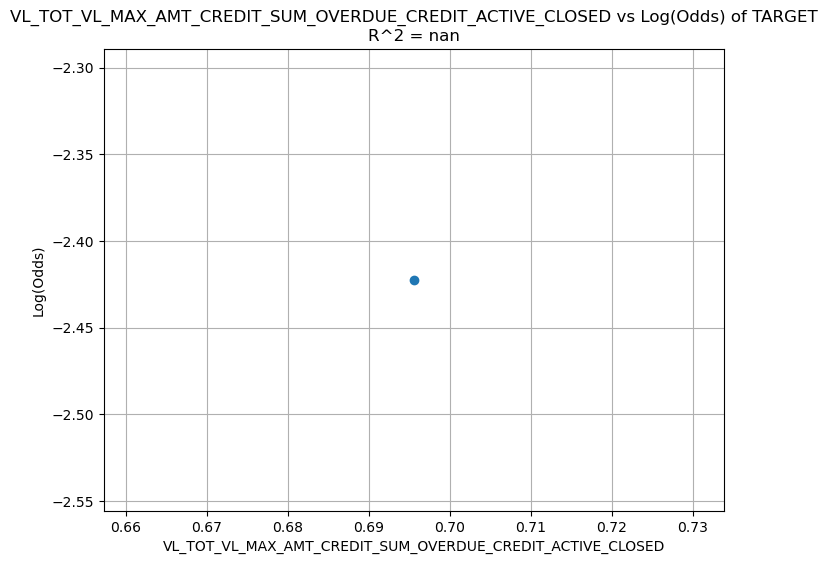

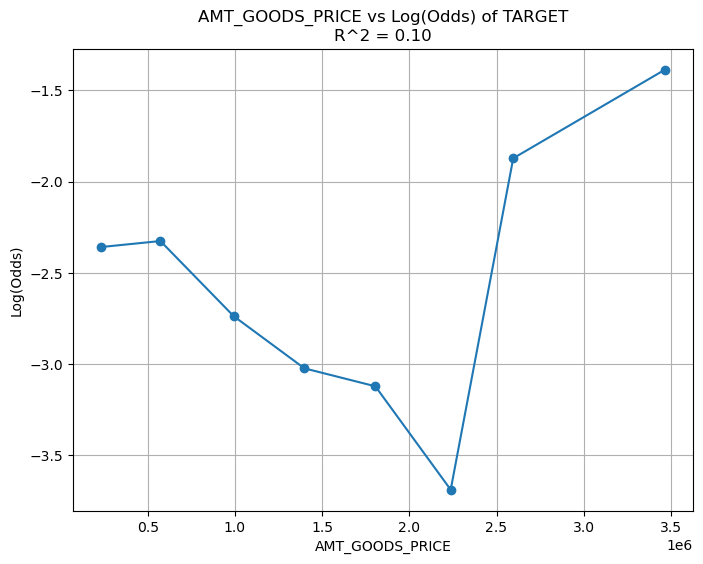

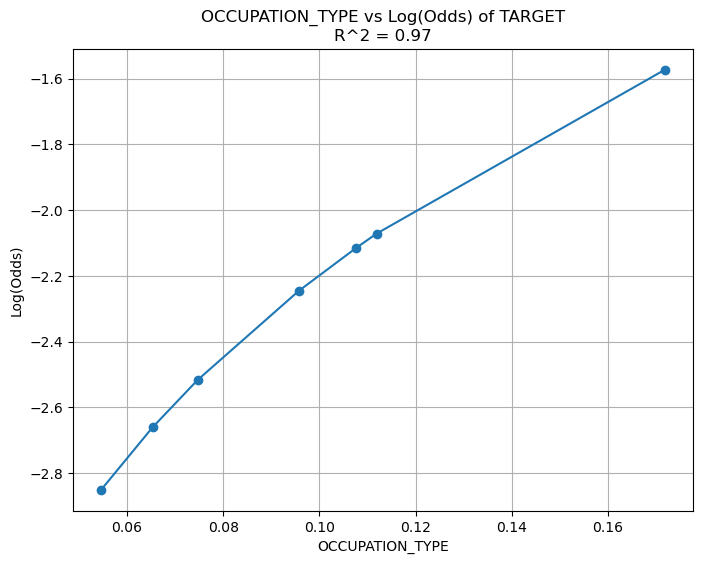

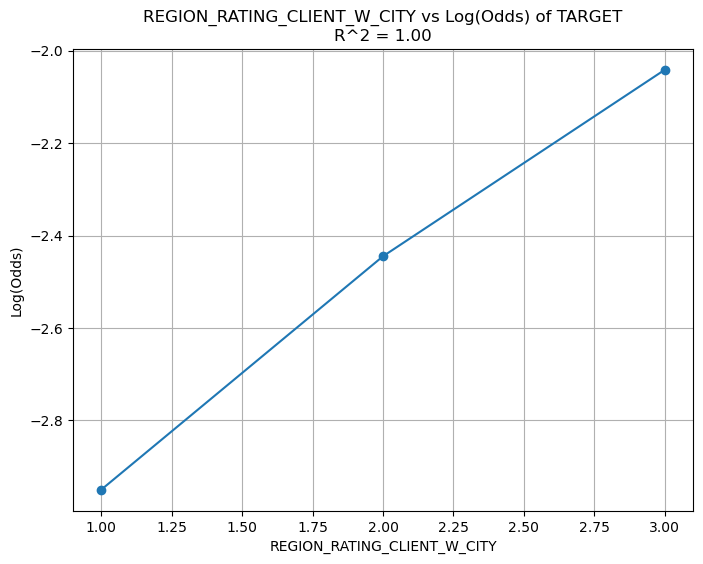

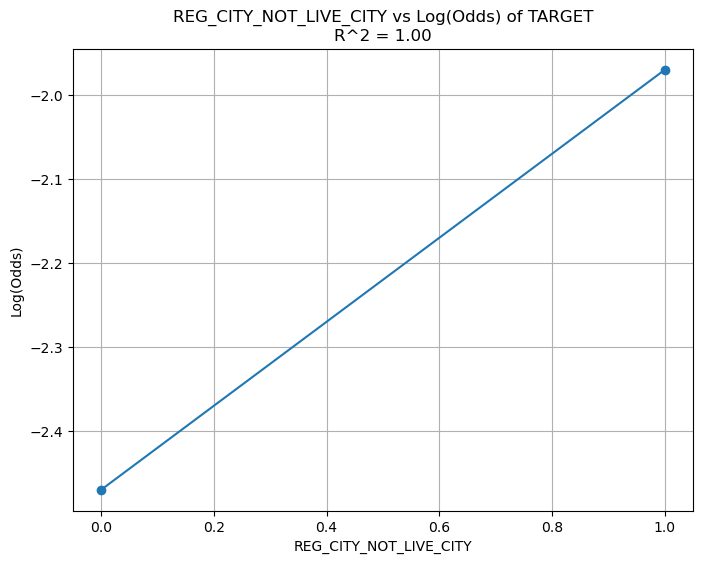

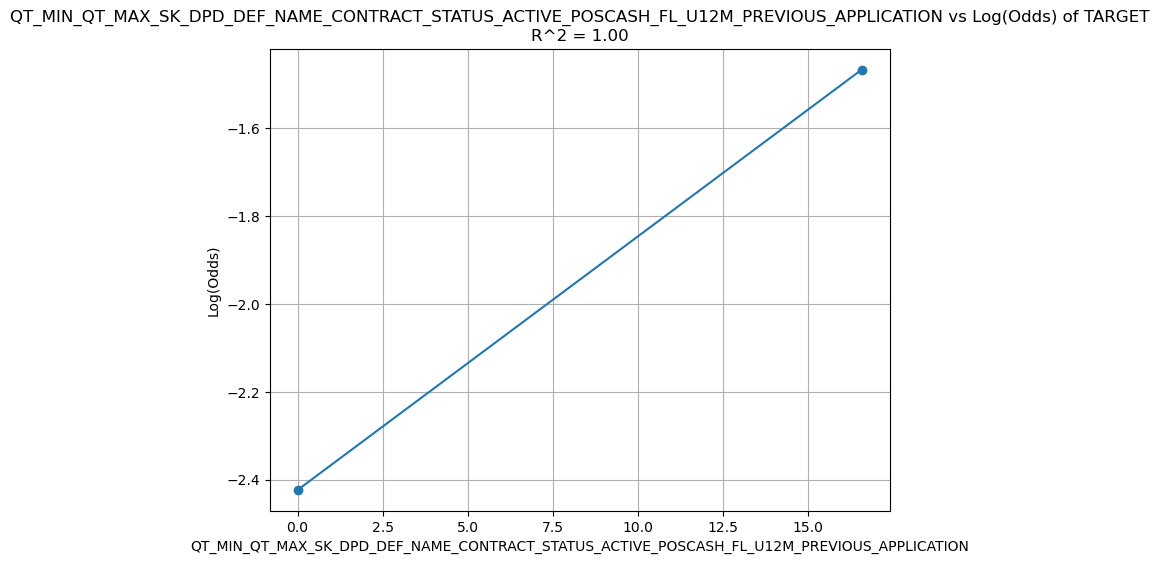

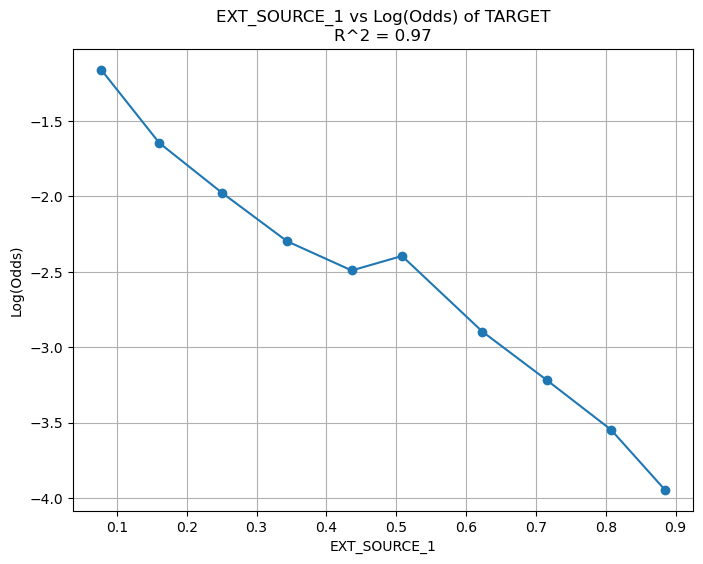

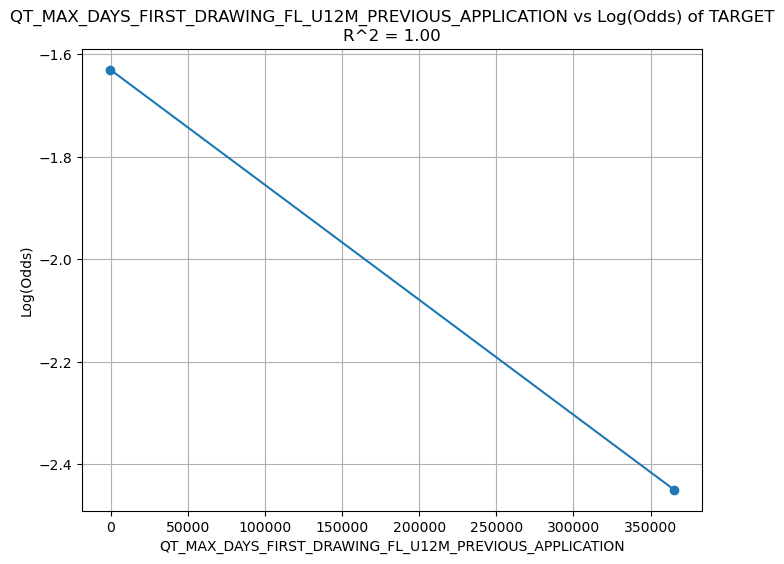

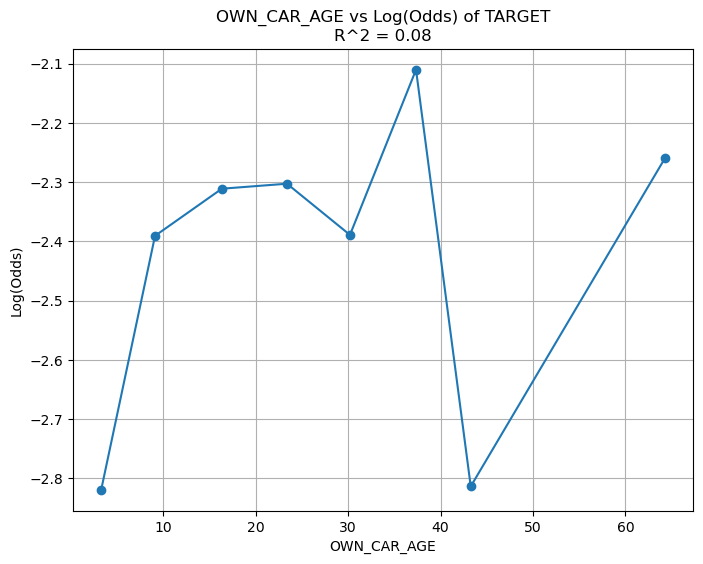

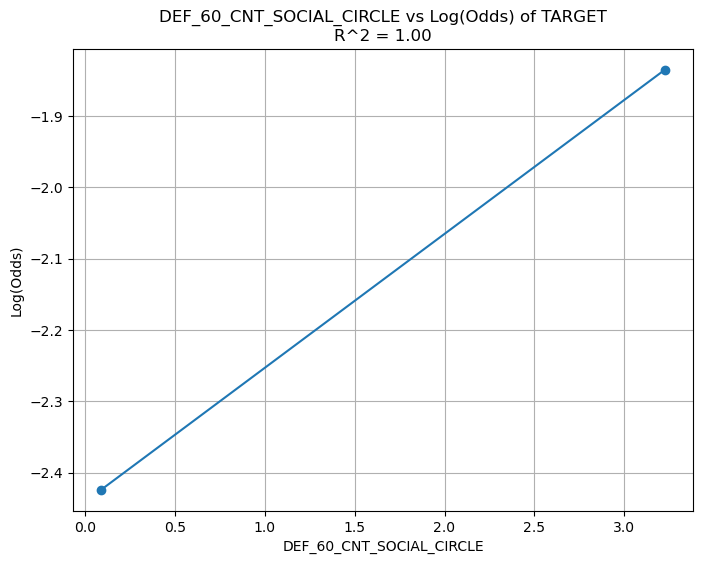

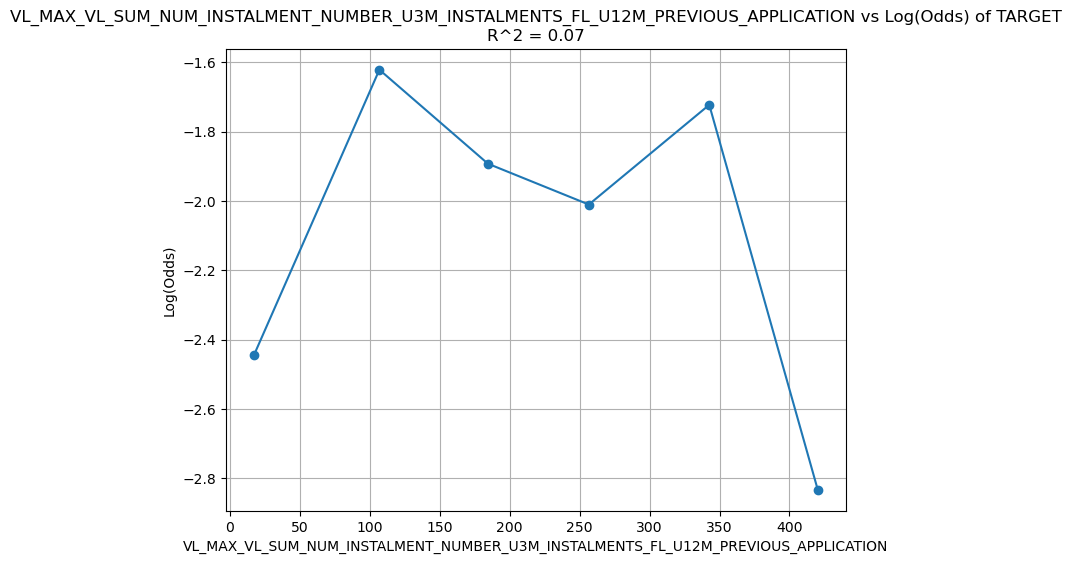

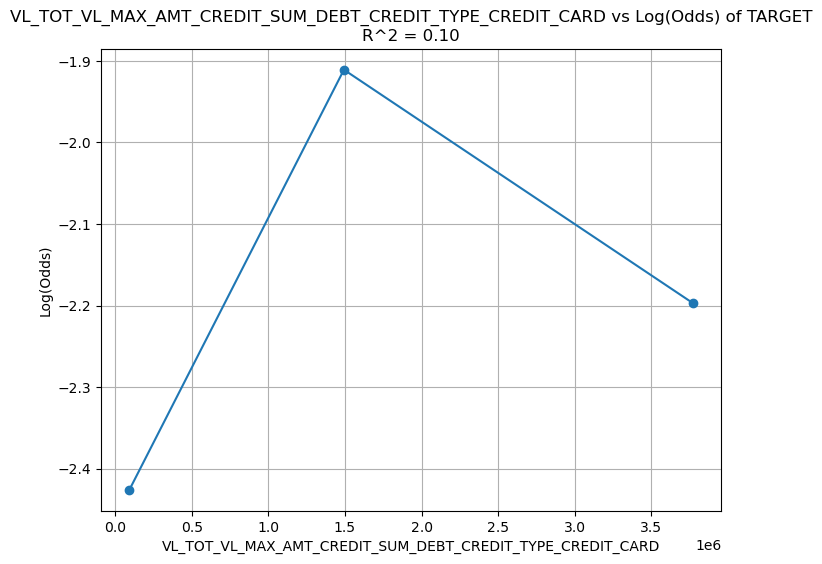

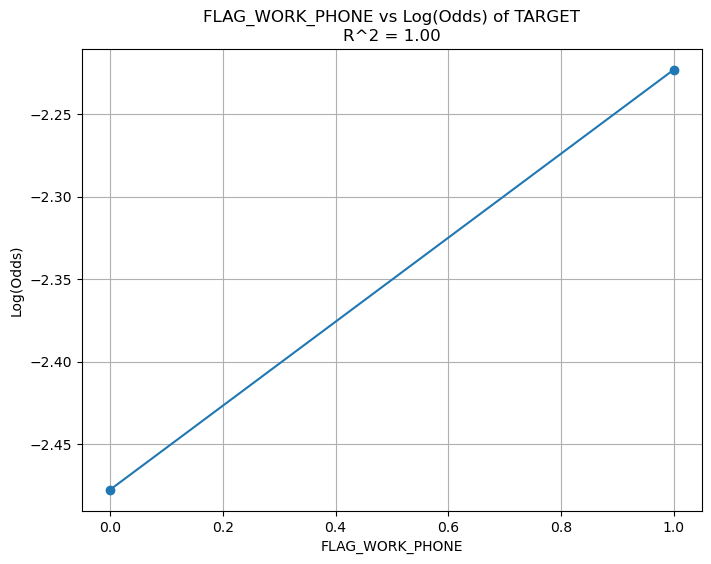

In [ ]:
plot_variable_vs_logodds(abt_train_full, list(abt_train_full.drop(columns=['TARGET']).columns), 'TARGET')

* Criando a Tabela para tomada de decisão acerca das variáveis

In [ ]:
lin_df = calculate_r2_for_logodds(abt_train_full, list(abt_train_full.drop(columns= ['TARGET']).columns), 'TARGET', threshold= 0.85)
lin_df

,Variable,R^2,Feat Eng
0,EXT_SOURCE_3,0.978466,Usar como contínua
1,EXT_SOURCE_2,0.967878,Usar como contínua
2,NAME_EDUCATION_TYPE,0.968486,Usar como contínua
3,NAME_CONTRACT_TYPE,1.000000,Usar como contínua
4,FLAG_OWN_CAR,1.000000,Usar como contínua
5,CODE_GENDER,1.000000,Usar como contínua
6,ORGANIZATION_TYPE,0.950481,Usar como contínua
7,VL_TOT_VL_MAX_AMT_CREDIT_SUM_OVERDUE_CREDIT_AC...,NaN,Categorizar
8,AMT_GOODS_PRICE,0.095843,Categorizar
9,OCCUPATION_TYPE,0.972607,Usar como contínua


* Salvando as variáveis

In [ ]:
vars_continuas = lin_df.loc[lin_df['Feat Eng'] == 'Usar como contínua', 'Variable'].tolist()
vars_categorizar = lin_df.loc[~(lin_df['Feat Eng'] == 'Usar como contínua'), 'Variable'].tolist()

## Verificando Transformações Matemáticas

* Nas variáveis com baixo R², irei testar transformações matemáticas para tentar melhorar a linearidade

In [ ]:
transform_df = calculate_r2_for_logodds_and_transformations(abt_train_full, vars_categorizar, 'TARGET', threshold=0.85)
transform_df

,Variable,Best Transformation,R^2 of Transformation,Feat Eng,Transformation Equation
0,VL_TOT_VL_MAX_AMT_CREDIT_SUM_OVERDUE_CREDIT_AC...,AbsLog,0.018054,Categorizar,AbsLog(VL_TOT_VL_MAX_AMT_CREDIT_SUM_OVERDUE_CR...
1,AMT_GOODS_PRICE,Quadratic,0.379131,Categorizar,Quadratic(AMT_GOODS_PRICE)
2,OWN_CAR_AGE,AbsLog,0.389392,Categorizar,AbsLog(OWN_CAR_AGE)
3,VL_MAX_VL_SUM_NUM_INSTALMENT_NUMBER_U3M_INSTAL...,Quadratic,0.639222,Categorizar,Quadratic(VL_MAX_VL_SUM_NUM_INSTALMENT_NUMBER_...
4,VL_TOT_VL_MAX_AMT_CREDIT_SUM_DEBT_CREDIT_TYPE_...,AbsLog,0.535312,Categorizar,AbsLog(VL_TOT_VL_MAX_AMT_CREDIT_SUM_DEBT_CREDI...


* Aplicando as melhores transformações

In [ ]:
abt_train_full_transformed = apply_best_transformations(transform_df, abt_train_full, drop_original = True)
abt_test_full_transformed = apply_best_transformations(transform_df, abt_test_full, drop_original = True)

* Atualizando a lista de variáveis contínuas, caso a transformação tenha conseguido melhorar alguma

In [ ]:
var = list(transform_df.loc[transform_df['Feat Eng'] == 'Usar como contínua'].Variable)
var = ["TFE_" + variavel for variavel in var]
vars_continuas += var

# Categorização

* Aplicando categorização para variáveis com baixo R² (ou seja, não possuem linearidade com a LogOdds)

In [ ]:
# Calculando nova tabela de R² após transformações
lin_df_transformed = calculate_r2_for_logodds(
    abt_train_full_transformed,
    list(abt_train_full_transformed.drop(columns= ['TARGET'])),
    'TARGET',
    threshold=0.85
)

# Atualizando a Lista de variáveis a serem categorizadas
vars_categorizar = lin_df_transformed.loc[lin_df_transformed['Feat Eng'] == 'Categorizar', 'Variable'].tolist()

* Checando cardinalidade das variáveis a serem categorizadas

In [ ]:
generate_metadata(abt_train_full_transformed[vars_categorizar])

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,VL_TOT_VL_MAX_AMT_CREDIT_SUM_OVERDUE_CREDIT_AC...,float64,0,0.0,44
1,AMT_GOODS_PRICE,float64,0,0.0,702
2,OWN_CAR_AGE,float64,0,0.0,56
3,VL_MAX_VL_SUM_NUM_INSTALMENT_NUMBER_U3M_INSTAL...,float64,0,0.0,333
4,VL_TOT_VL_MAX_AMT_CREDIT_SUM_DEBT_CREDIT_TYPE_...,float64,0,0.0,41579


* Aplicando a Categorização

In [ ]:
print('------------------------------- INÍCIO DA CATEGORIZAÇÃO ----------------------------')
print(f'------------------------------- {len(vars_categorizar)} VARIÁVEIS ---------------------------------------')
n = 0
for var in vars_categorizar:
    if n == 0:
        result = categorize_with_decision_tree(abt_train_full_transformed, n_categories=3, target='TARGET', numeric_var=var)
        df1_treino = apply_tree_bins(abt_train_full_transformed, result, numeric_var=var)
        df1_teste = apply_tree_bins(abt_test_full_transformed, result, numeric_var=var)
    elif n == 1:
        result = categorize_with_decision_tree(df1_treino, n_categories=4, target='TARGET', numeric_var=var)
        df1_treino = apply_tree_bins(df1_treino, result, numeric_var=var)
        df1_teste = apply_tree_bins(df1_teste, result, numeric_var=var)
    elif n == 2:
        result = categorize_with_decision_tree(df1_treino, n_categories=5, target='TARGET', numeric_var=var)
        df1_treino = apply_tree_bins(df1_treino, result, numeric_var=var)
        df1_teste = apply_tree_bins(df1_teste, result, numeric_var=var)
    else:
        result = categorize_with_decision_tree(df1_treino, n_categories=4, target='TARGET', numeric_var=var)
        df1_treino = apply_tree_bins(df1_treino, result, numeric_var=var)
        df1_teste = apply_tree_bins(df1_teste, result, numeric_var=var)
    n += 1
    print(f'------------------------------- FIM DA {n}ª ITERAÇÃO ---------------------------------')

var = ["TFT_" + palavra for palavra in vars_categorizar]

------------------------------- INÍCIO DA CATEGORIZAÇÃO ----------------------------
------------------------------- 5 VARIÁVEIS ---------------------------------------
------------------------------- FIM DA 1ª ITERAÇÃO ---------------------------------
------------------------------- FIM DA 2ª ITERAÇÃO ---------------------------------
------------------------------- FIM DA 3ª ITERAÇÃO ---------------------------------
------------------------------- FIM DA 4ª ITERAÇÃO ---------------------------------
------------------------------- FIM DA 5ª ITERAÇÃO ---------------------------------


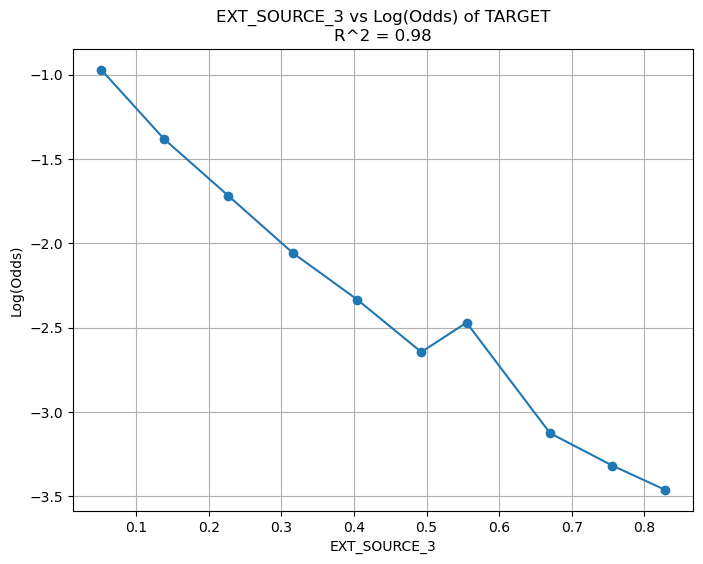

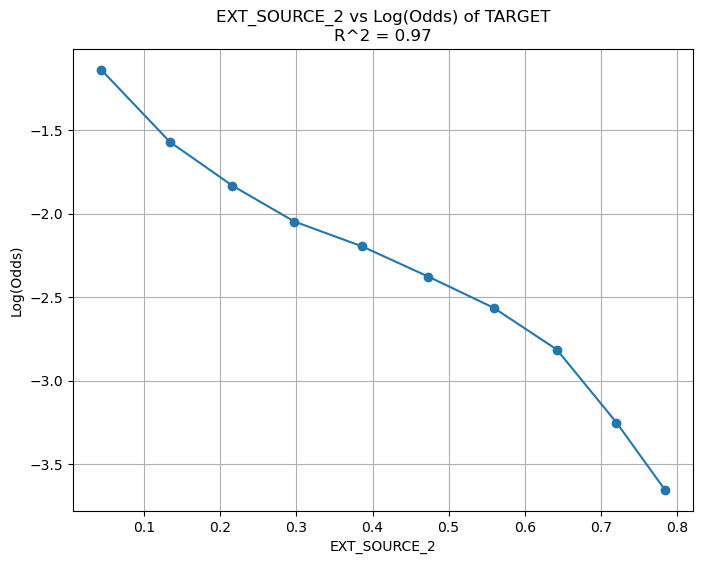

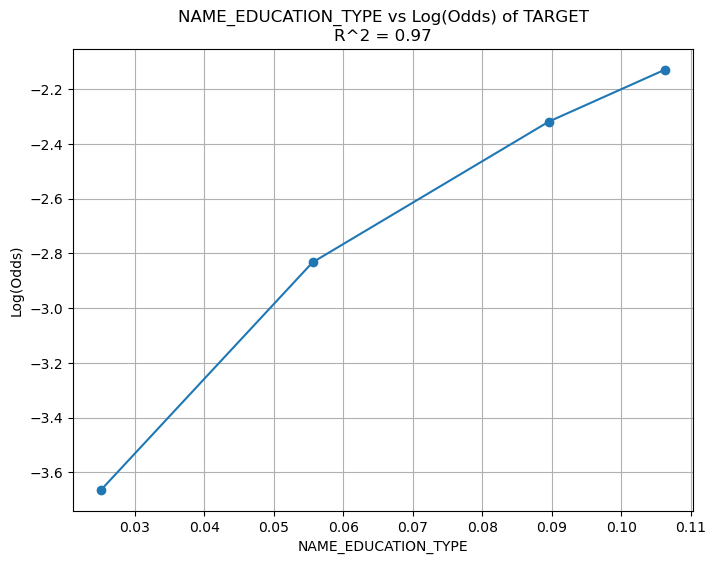

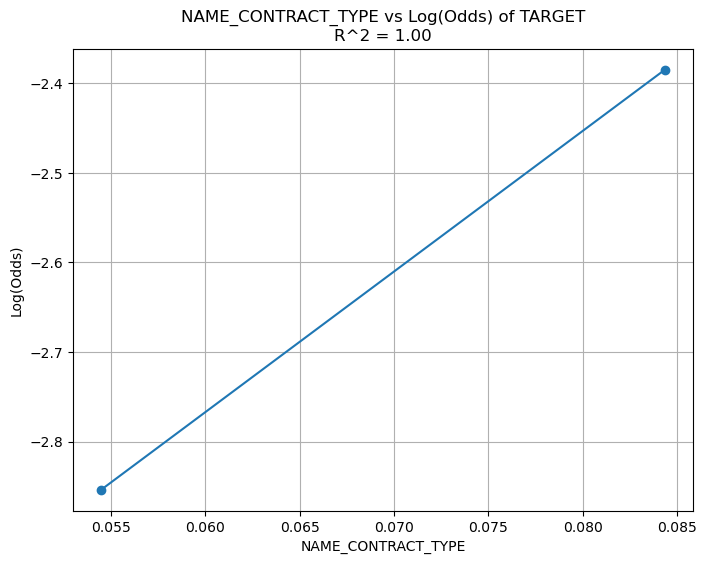

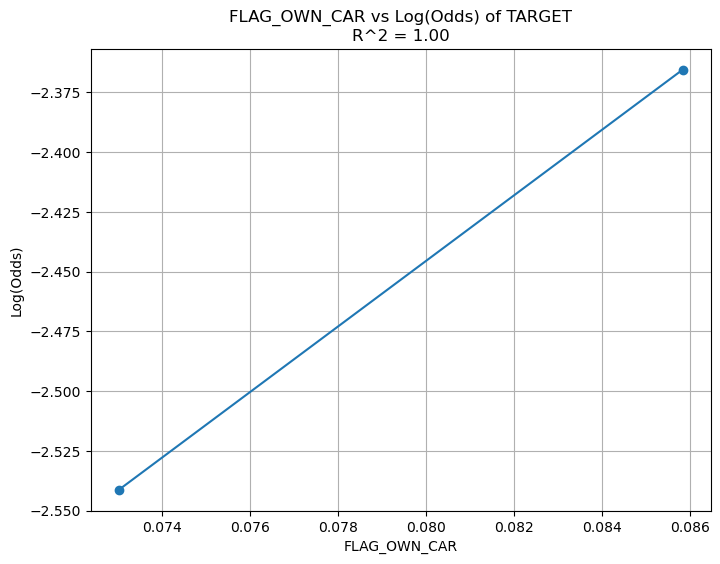

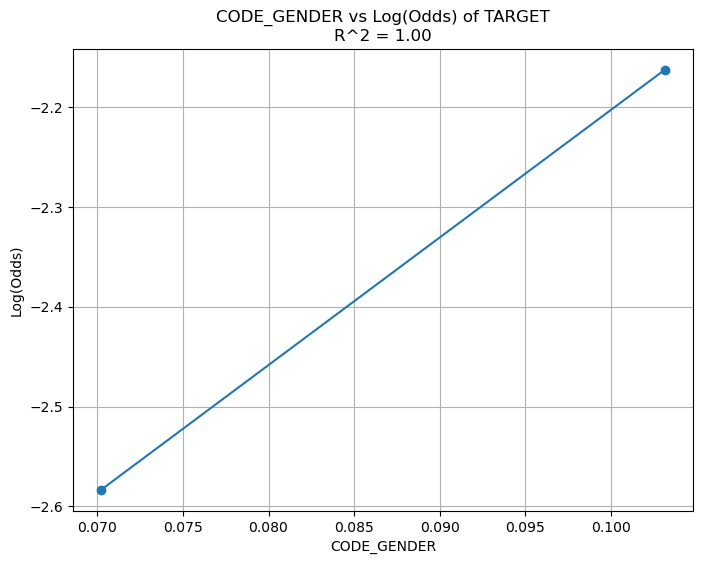

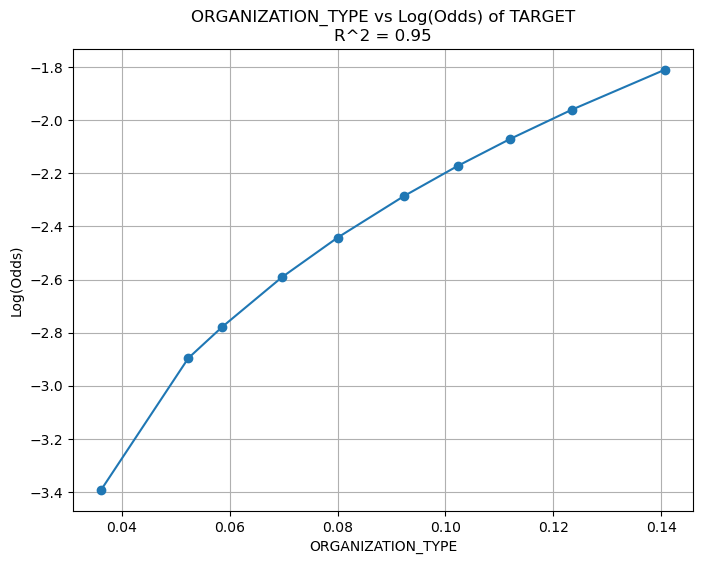

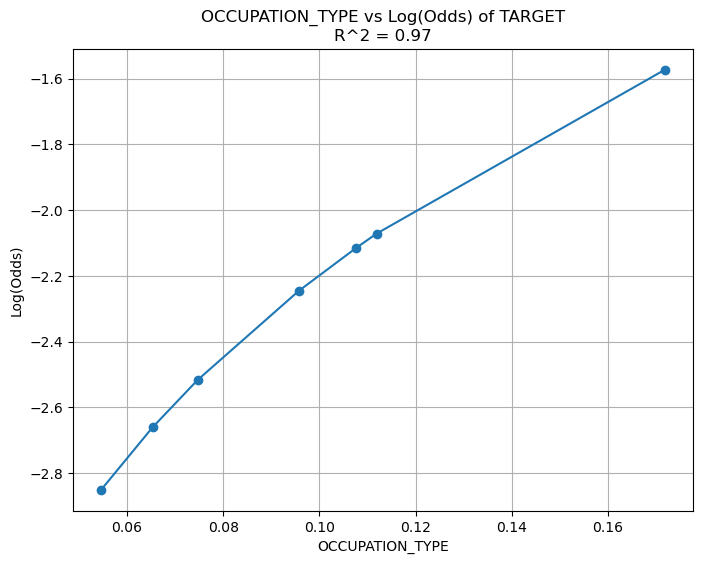

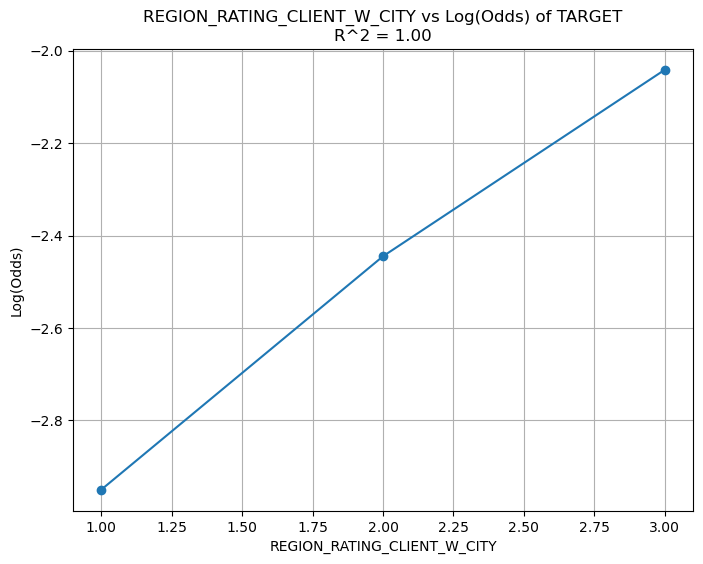

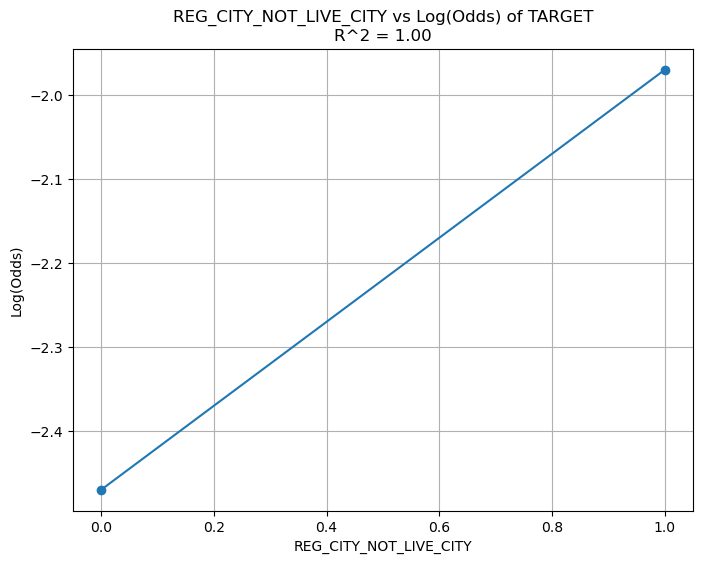

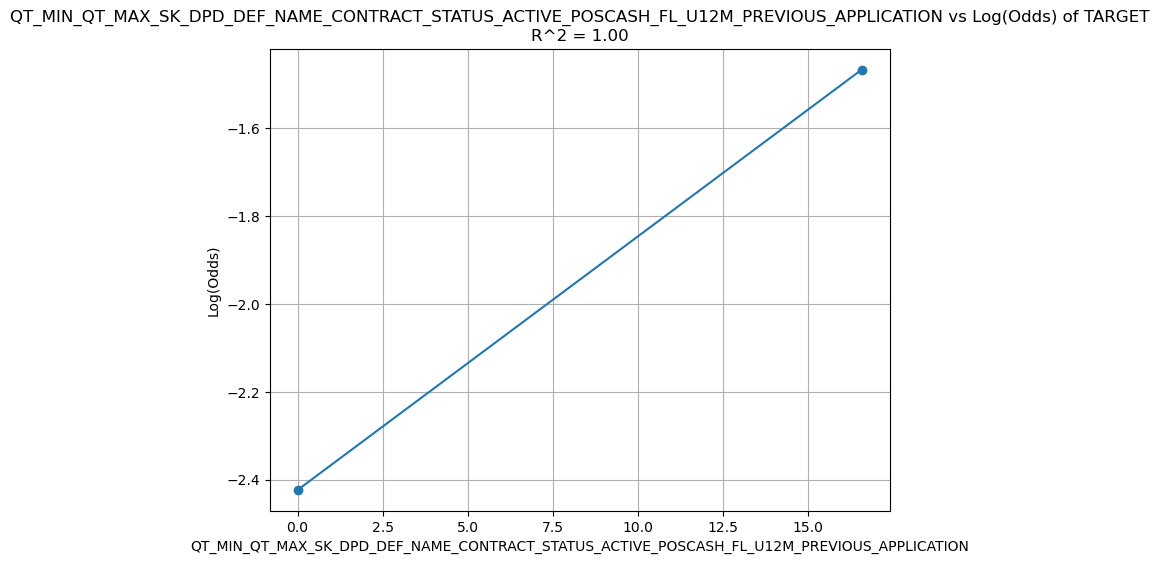

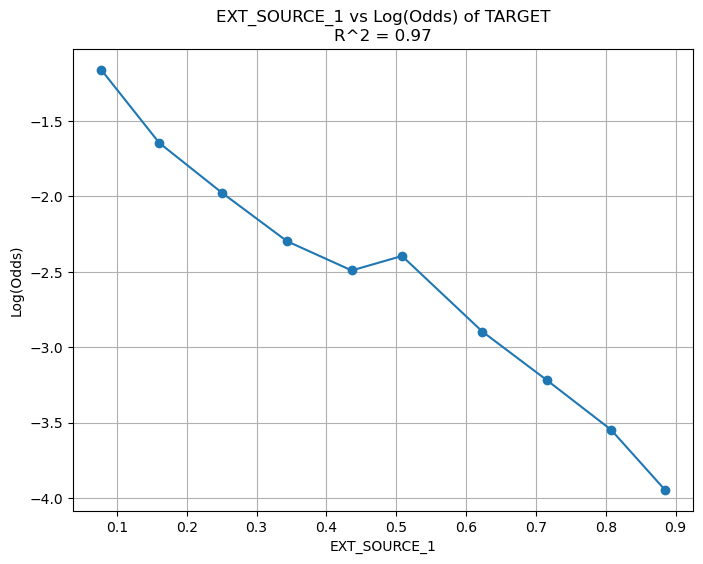

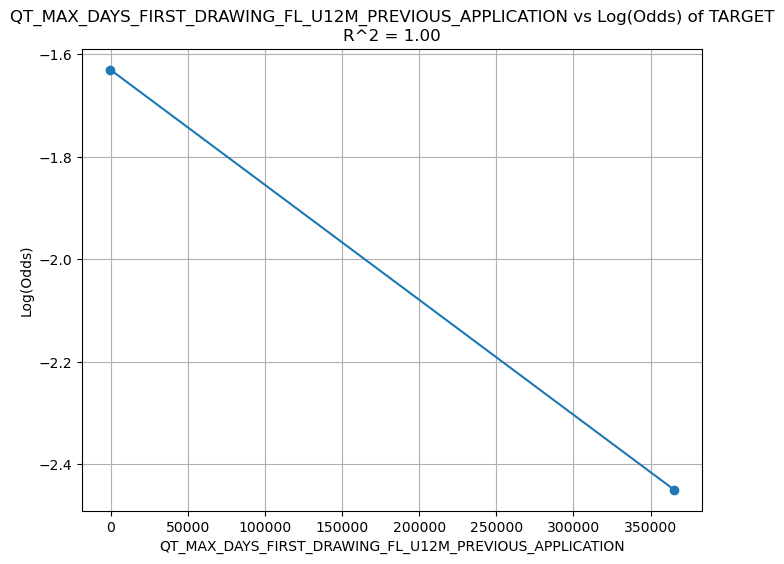

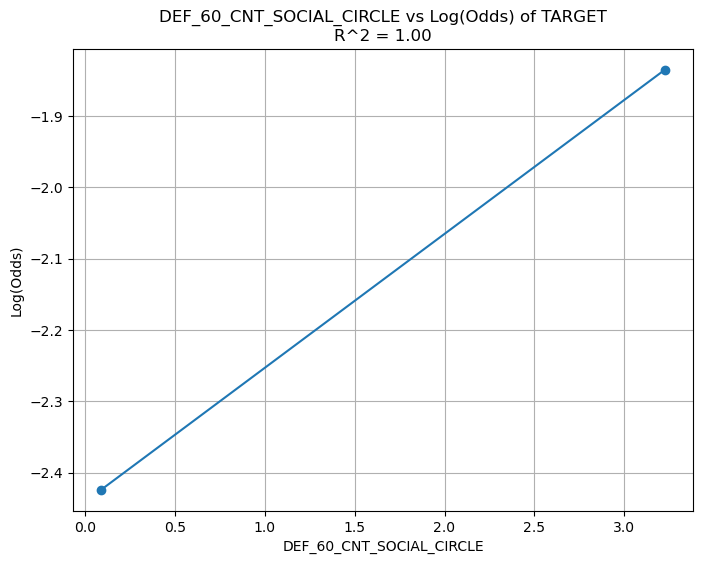

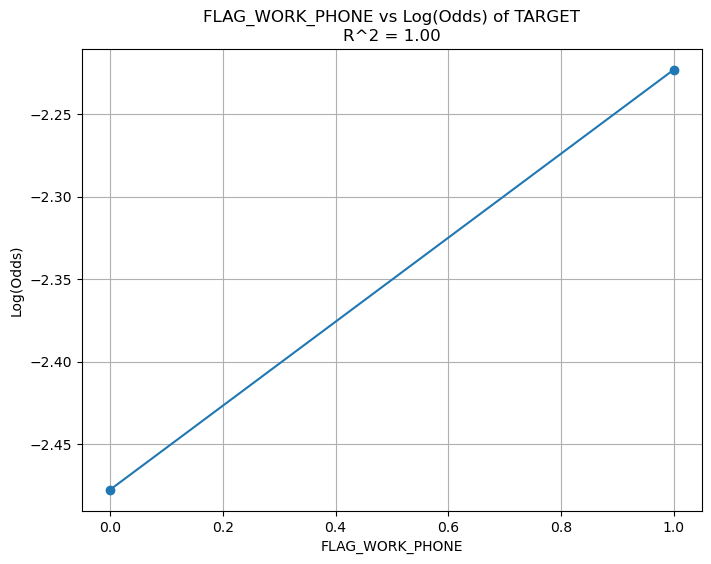

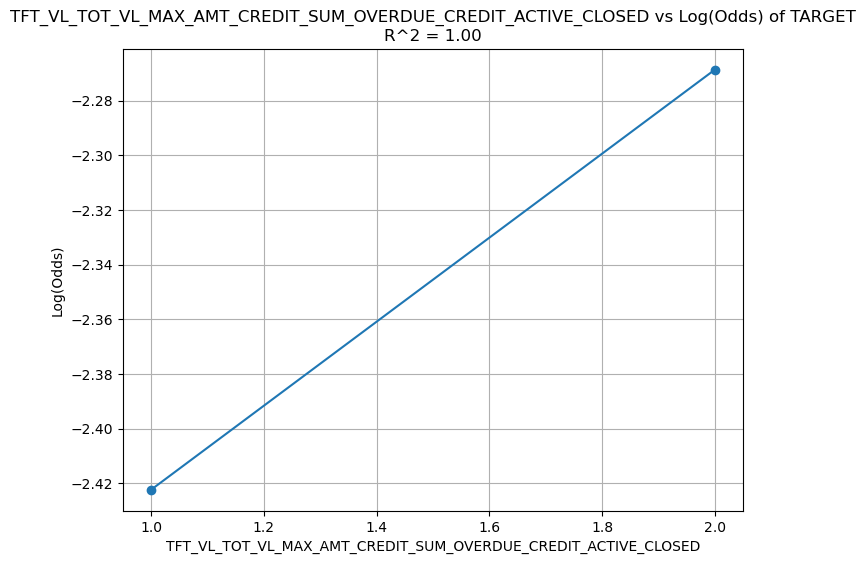

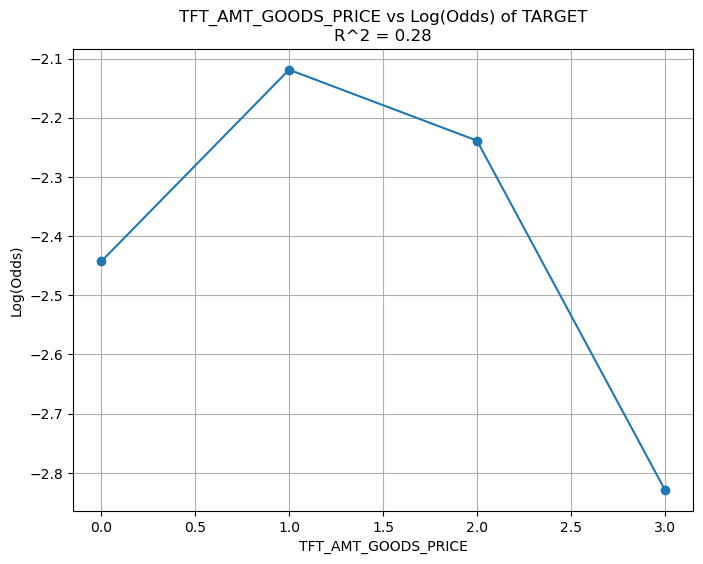

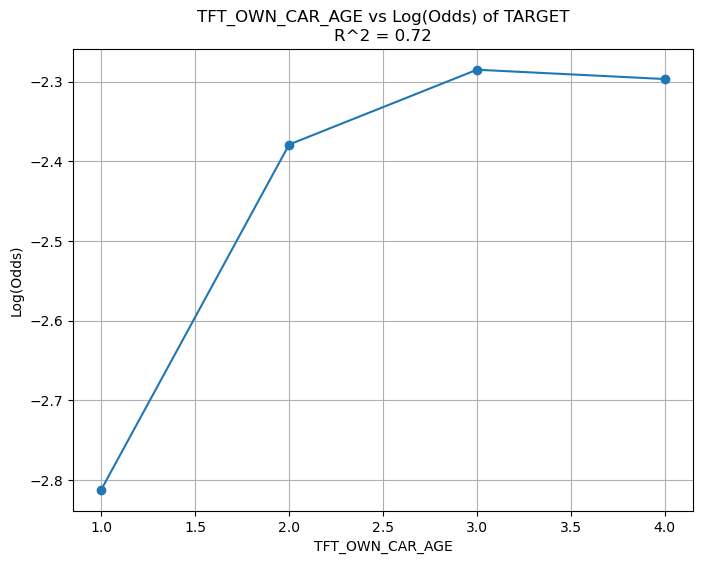

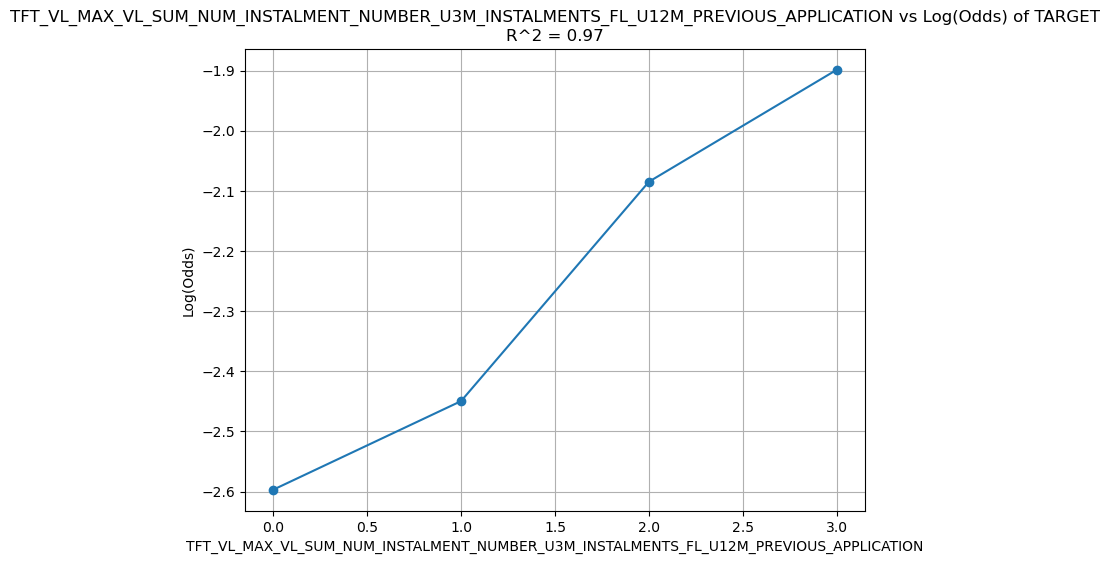

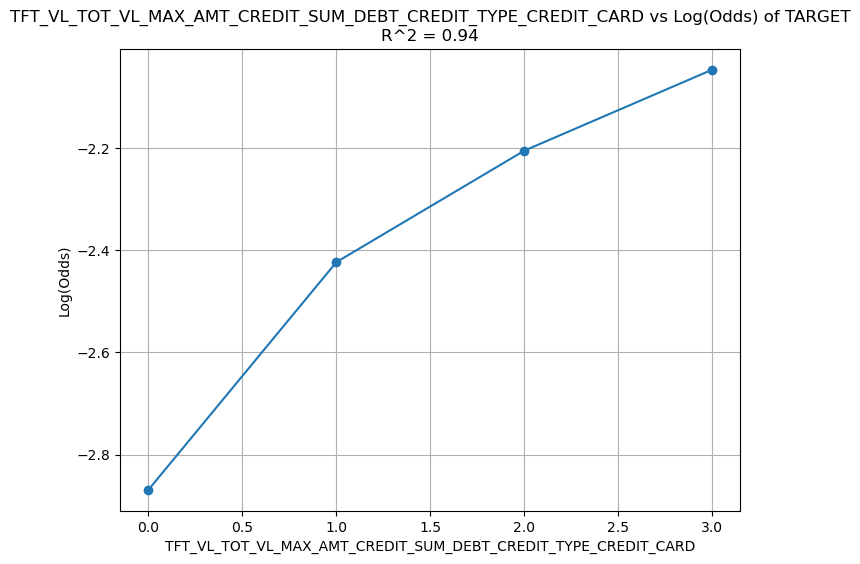

In [ ]:
plot_variable_vs_logodds(df1_treino, list(df1_treino.drop(columns=['TARGET']).columns), 'TARGET')

* Verificando a Ordenação das Variáveis Após a Transformação 

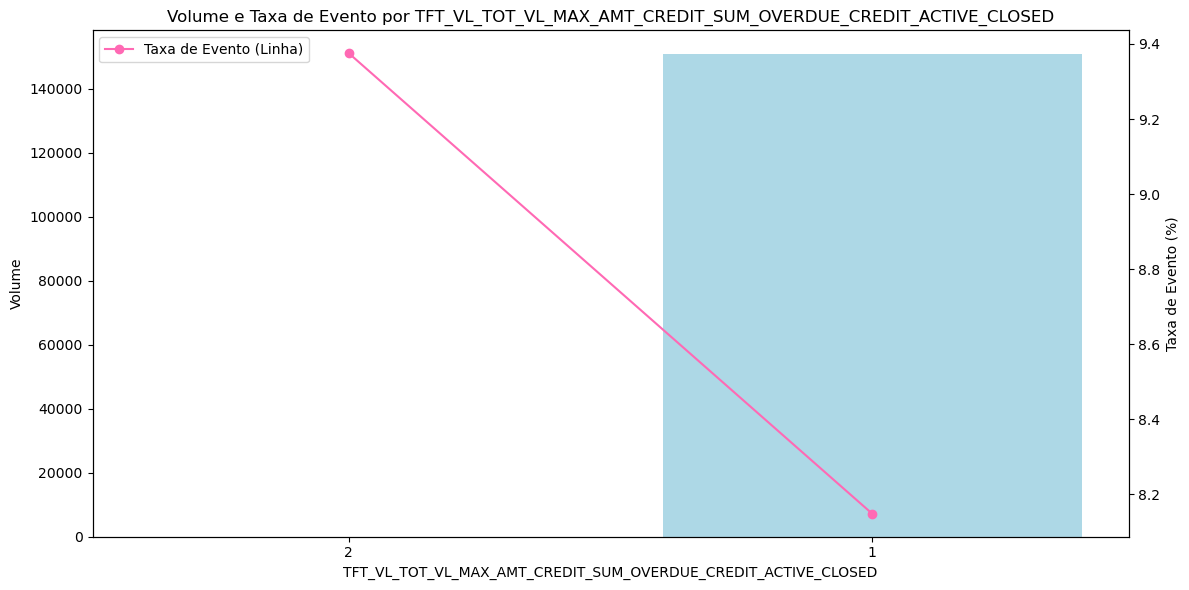

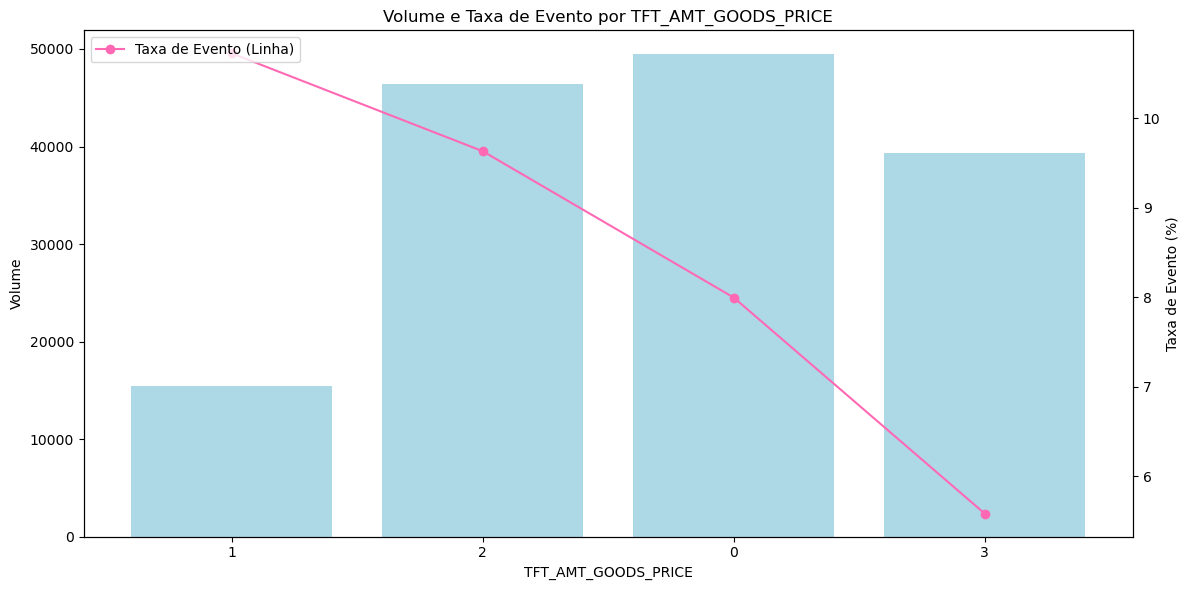

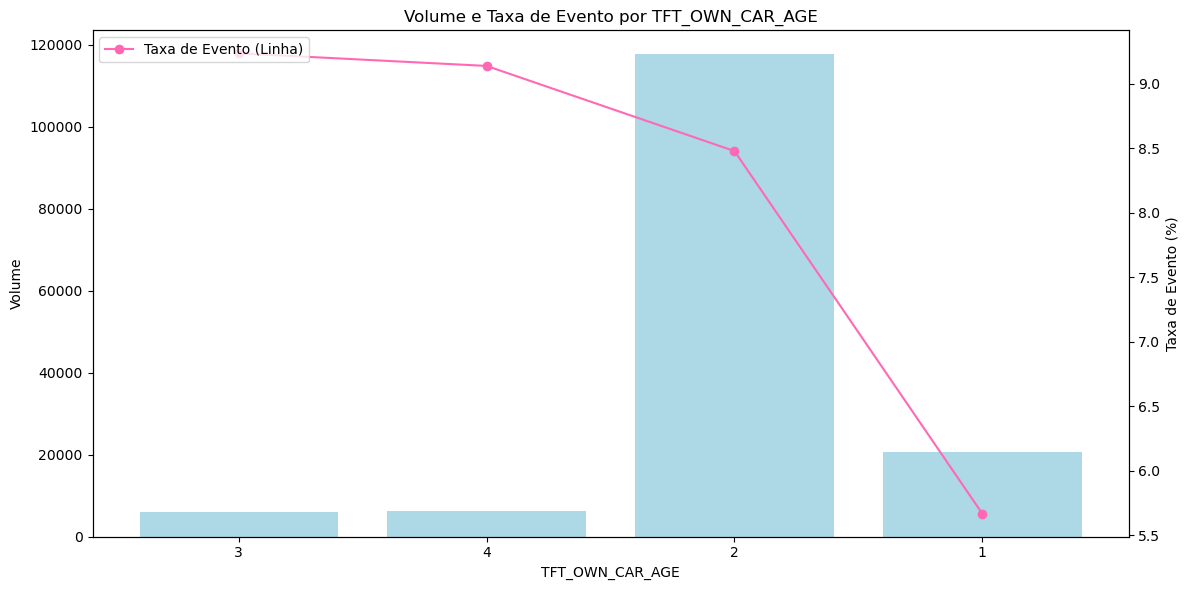

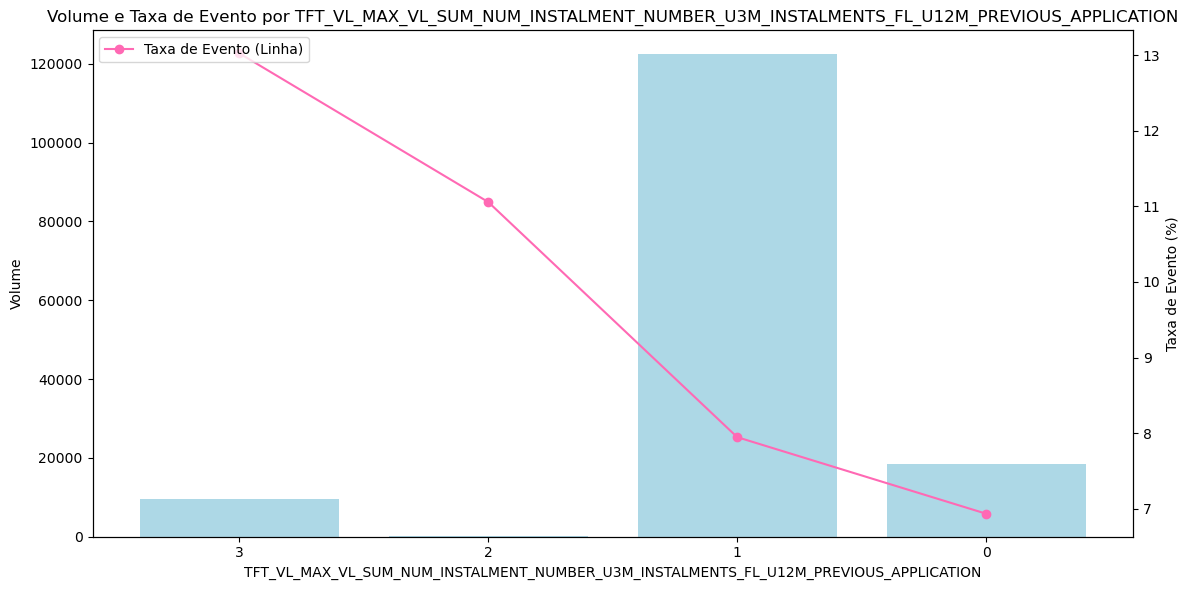

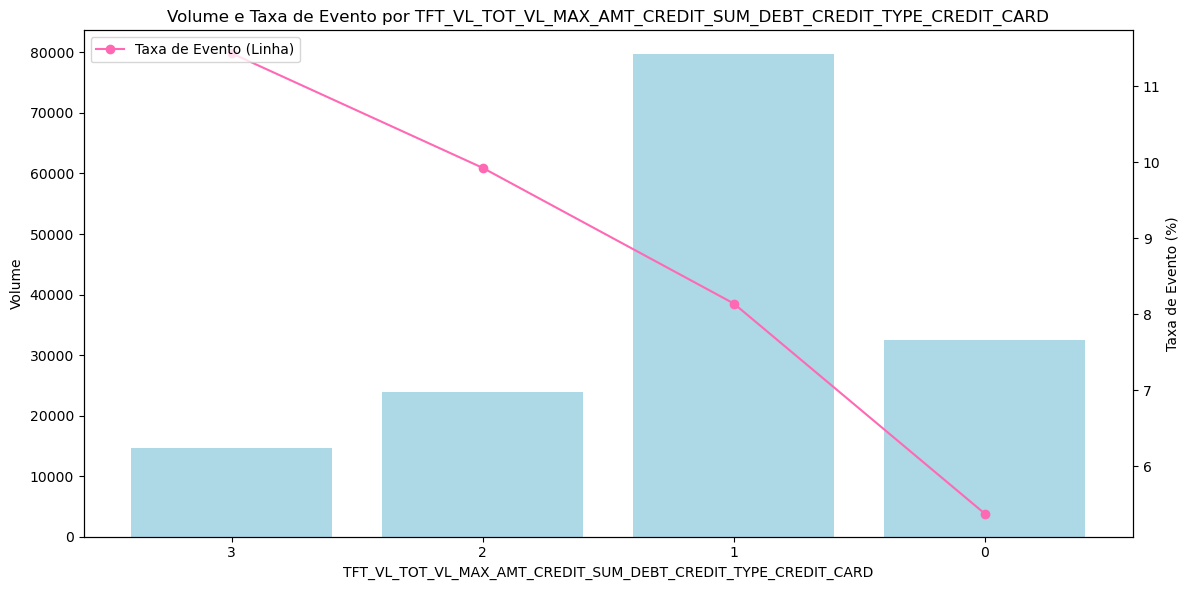

In [ ]:
# Aqui o comportamento deve ser monotonico, ou seja, precisa apresentar ou uma queda ou uma subida, durante toda a faixa
for variavel in var:
    analyze_variable(df1_treino, variavel, 'TARGET')

* Aplicando o encoding as variáveis categorizadas

In [ ]:
# var contem a lista de variáveis que foram categorizadas
for variavel in var:
    df1_treino[variavel] = df1_treino[variavel].astype(float)
    df1_teste[variavel] = df1_teste[variavel].astype(float)


# Instanciando o Encoder
encoder = OneHotEncoder(drop= 'first', sparse_output=False, handle_unknown='ignore',dtype=np.int32)


# Aplicando o Encoder - Conjunto de Treino Categorizado
encoded_data = encoder.fit_transform(df1_treino[var])
encoded_cols = encoder.get_feature_names_out(var)
encoded_df = pd.DataFrame(encoded_data, columns= encoded_cols, index = df1_treino.index)

abt_train_cat_encoded = pd.concat([df1_treino.drop(columns= var), encoded_df], axis=1)


# Aplicando o Encoder - Conjunto de Teste Categorizado
encoded_data = encoder.transform(df1_teste[var])
encoded_cols = encoder.get_feature_names_out(var)
encoded_df = pd.DataFrame(encoded_data, columns= encoded_cols, index = df1_teste.index)

abt_test_cat_encoded = pd.concat([df1_teste.drop(columns= var), encoded_df], axis=1)


# Criando o dataframe sem o target, com as variáveis categorizadas após o encoding
X = abt_train_cat_encoded.drop(columns= ['TARGET'])


# Lista com as features finais
vars_final = list(X.columns)

# Aplicando o Modelo e Avaliando o Resultado

* Aplicando a Regressão Logística

In [ ]:
model, scorecard = logistic_regression_with_scorecard(abt_train_cat_encoded, 'TARGET', vars_final)

Optimization terminated successfully.
         Current function value: 0.252290
         Iterations 8


In [ ]:
scorecard

,Beta Coefficient,P-Value,Wald Statistic
EXT_SOURCE_2,-2.145261e+00,0.000000e+00,1897.672562
EXT_SOURCE_3,-2.497780e+00,0.000000e+00,1874.889747
const,-5.469212e+00,4.184963e-96,432.707103
EXT_SOURCE_1,-1.222648e+00,1.200664e-65,292.832357
ORGANIZATION_TYPE,8.399421e+00,1.314801e-53,237.596163
CODE_GENDER,9.394816e+00,3.376465e-43,189.880285
TFT_VL_TOT_VL_MAX_AMT_CREDIT_SUM_DEBT_CREDIT_TYPE_CREDIT_CARD_3.0,4.391254e-01,1.776173e-30,131.659469
TFT_VL_TOT_VL_MAX_AMT_CREDIT_SUM_DEBT_CREDIT_TYPE_CREDIT_CARD_1.0,2.918998e-01,3.460126e-24,102.936798
NAME_CONTRACT_TYPE,1.312104e+01,2.469341e-22,94.485181
NAME_EDUCATION_TYPE,7.430119e+00,6.449095e-22,92.585106


* A variável `TFT_VL_TOT_VL_MAX_AMT_CREDIT_SUM_OVERDUE_CREDIT_ACTIVE_CLOSED_2.0` ficou com p-valor acima do nível de significancia. Irei remove-la.

In [ ]:
accepted_vars = scorecard.loc[scorecard['P-Value']<=0.05].index.tolist()

try:
    accepted_vars.remove('const')
except:
    pass

abt_train_final = abt_train_cat_encoded[accepted_vars]
abt_train_final = pd.concat([abt_train_final, y_train], axis=1)

abt_test_final = abt_test_cat_encoded[accepted_vars]
abt_test_final = pd.concat([abt_test_final, y_test], axis=1)

* Retreinando o Modelo

In [ ]:
model, scorecard = logistic_regression_with_scorecard(
    abt_train_final,
    'TARGET',
    list(abt_train_final.drop(columns= ['TARGET']).columns)
)

scorecard

Optimization terminated successfully.
         Current function value: 0.252291
         Iterations 8


,Beta Coefficient,P-Value,Wald Statistic
EXT_SOURCE_2,-2.145038e+00,0.000000e+00,1897.425293
EXT_SOURCE_3,-2.497755e+00,0.000000e+00,1874.870737
const,-5.468996e+00,4.253893e-96,432.674505
EXT_SOURCE_1,-1.222713e+00,1.179141e-65,292.868411
ORGANIZATION_TYPE,8.397888e+00,1.368562e-53,237.516345
CODE_GENDER,9.396141e+00,3.283074e-43,189.936092
TFT_VL_TOT_VL_MAX_AMT_CREDIT_SUM_DEBT_CREDIT_TYPE_CREDIT_CARD_3.0,4.391309e-01,1.771602e-30,131.664584
TFT_VL_TOT_VL_MAX_AMT_CREDIT_SUM_DEBT_CREDIT_TYPE_CREDIT_CARD_1.0,2.918693e-01,3.495324e-24,102.916747
NAME_CONTRACT_TYPE,1.311985e+01,2.487019e-22,94.471061
NAME_EDUCATION_TYPE,7.430136e+00,6.445851e-22,92.586102


In [ ]:
abt_train_final_ord = abt_train_final.drop(columns= ['TARGET']).copy()
abt_test_final_ord = abt_test_final.drop(columns= ['TARGET']).copy()

abt_train_final_ord['const'] = 1.0
abt_test_final_ord['const'] = 1.0

abt_train_final_ord['Score_1'] = model.predict(abt_train_final_ord).round(4)
abt_test_final_ord['Score_1'] = model.predict(abt_test_final_ord).round(4)

abt_train_final_ord['Score_0'] = 1 - abt_train_final_ord['Score_1']
abt_test_final_ord['Score_0'] = 1 - abt_test_final_ord['Score_1']

abt_train_final_ord = pd.concat([abt_train_final_ord, y_train], axis=1)
abt_test_final_ord = pd.concat([abt_test_final_ord, y_test], axis=1)

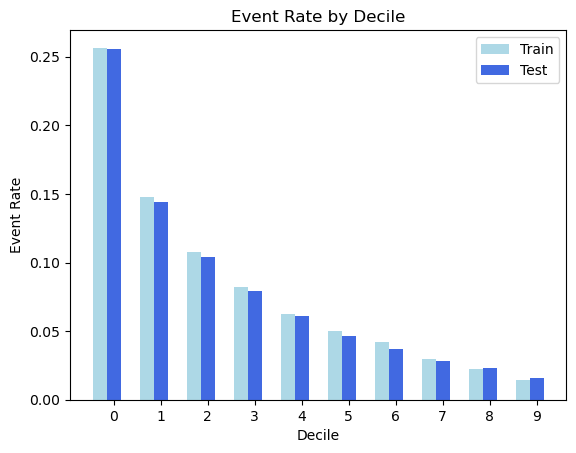

,Metric,Train Value,Test Value
0,KS,0.363068,0.366113
1,AUC,0.743848,0.745137
2,Gini,0.487695,0.490274


In [ ]:
metrics, ord_score_train, ord_score_test = calculate_metrics(abt_train_final_ord, abt_test_final_ord, 'Score_1', 'Score_0', 'TARGET',bins=10)
metrics

In [ ]:
ord_score_train

,decile,min_score,max_score,event_rate,volume
0,0,0.0625,0.8255,0.256550,15077
1,1,0.8256,0.8806,0.147819,15059
2,2,0.8807,0.9095,0.107486,15109
3,3,0.9096,0.9287,0.082079,15083
4,4,0.9288,0.9428,0.062379,15037
5,5,0.9429,0.9540,0.049927,15142
6,6,0.9541,0.9633,0.041811,15020
7,7,0.9634,0.9717,0.029896,15186
8,8,0.9718,0.9800,0.022270,14998
9,9,0.9801,0.9976,0.014164,14968


In [ ]:
ord_score_test

,decile,min_score,max_score,event_rate,volume
0,0,0.0978,0.8257,0.255882,6460
1,1,0.8258,0.8801,0.144450,6459
2,2,0.8802,0.9098,0.104019,6470
3,3,0.9099,0.9290,0.079090,6461
4,4,0.9291,0.9433,0.061019,6457
5,5,0.9434,0.9543,0.046666,6493
6,6,0.9544,0.9635,0.036709,6429
7,7,0.9636,0.9718,0.027991,6502
8,8,0.9719,0.9800,0.022805,6446
9,9,0.9801,0.9974,0.015935,6401
